#Kaggle Bike Sharing Demand

https://www.kaggle.com/c/bike-sharing-demand

- Bike_Sharing_Demand.csv(10,886 * 12)
  - datetime: Date + Timestamp
  - season: 1(봄), 2(여름), 3(가을), 4(겨울)
  - holiday
    - 1(토요일, 일요일을 제외한 공휴일)
    - 0(휴일이 아닌 날)
  - workingday
    - 1(토요일, 일요일 및 휴일이 아닌 주중)
    - 0(주말 및 휴일)
  - weather
    - 1(맑음, 약간흐림)
    - 2(안개, 흐림)
    - 3(가벼운 눈/비 + 천둥)
    - 4(심한 눈/비, 천둥/번개)
  - temp: 온도(섭씨)
  - atemp: 체감온도(섭씨)
  - humidity: 습도
  - windspeed: 풍속
  - casual: 사전 등록되지 않은 사용자 대여 횟수
  - registered: 사전 등록된 사용자 대여 횟수
  - count: 총 대여 횟수 -> y

- 수치예측 모델링 수행
- Metric -> np.sqrt(mse)
- 성능이 가장 좋은 모델 선택

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [161]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Data Load

In [3]:
url = "https://raw.githubusercontent.com/rusita-ai/pyData/master/Bike_Sharing_Demand.csv"

DF = pd.read_csv(url)

DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
DF.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Data Preprocessing

### 1) string -> date
- "year", "month", "day", "hour" 추출

In [5]:
DF['datetime'] = DF.datetime.apply(pd.to_datetime)

DF['year'] = DF.datetime.apply(lambda x : x.year)
DF['month'] = DF.datetime.apply(lambda x : x.month)
DF['day'] = DF.datetime.apply(lambda x : x.day)
DF['hour'] = DF.datetime.apply(lambda x : x.hour)

In [6]:
DF.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


### 2) Drop Columns
- 'datetime', 'casual', 'registered'

In [7]:
drop_columns = ['datetime' , 'casual' , 'registered']

DF.drop(drop_columns, axis = 1 , inplace = True)

In [8]:
DF.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


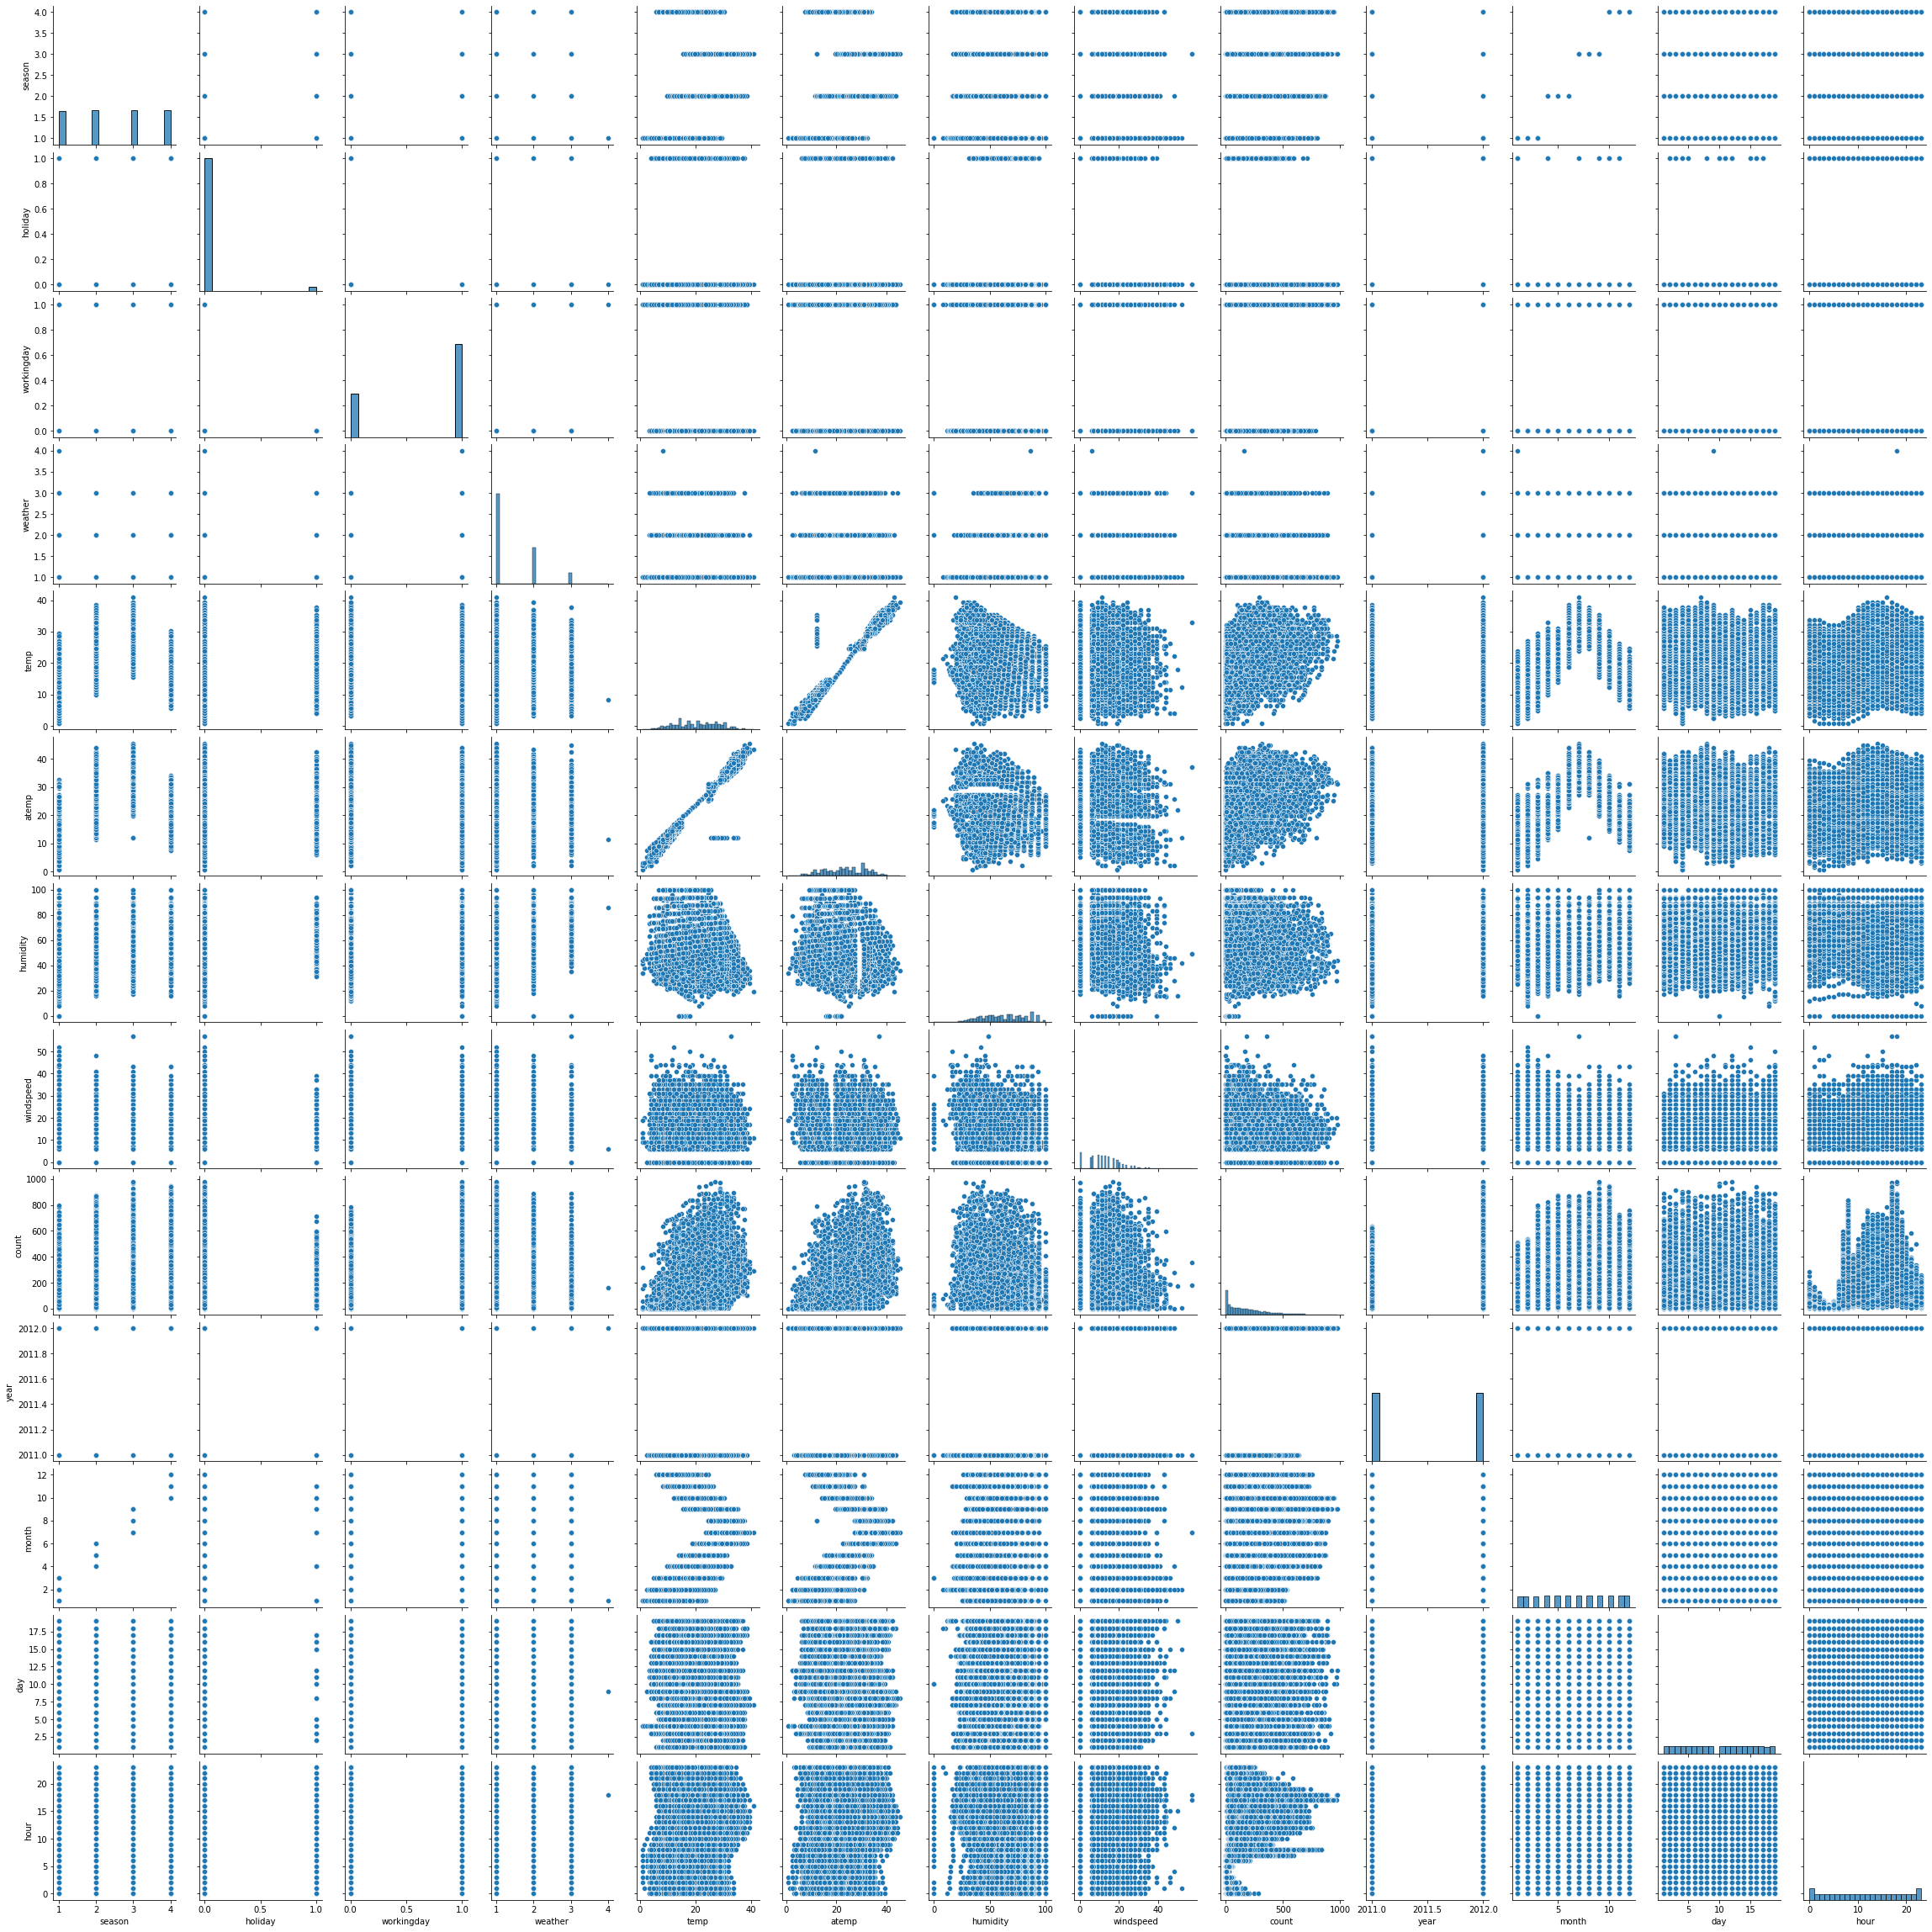

In [10]:
# pairplot

sns.pairplot(DF)
plt.show()

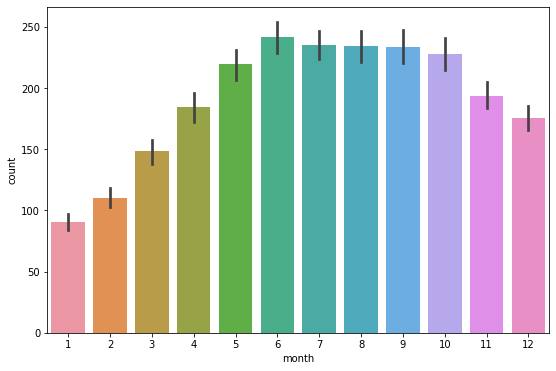

In [21]:
# barplot: 월별 count
plt.figure(figsize = (9, 6))
sns.barplot(x = 'month' , y = 'count', data = DF)
plt.show()

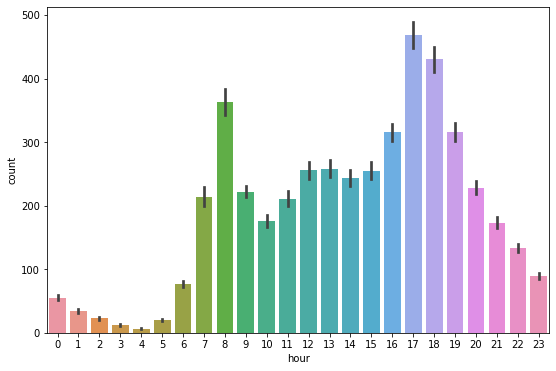

In [22]:
# barplot: 시간별 count
plt.figure(figsize = (9, 6))
sns.barplot(x = 'hour' , y = 'count', data = DF)
plt.show()

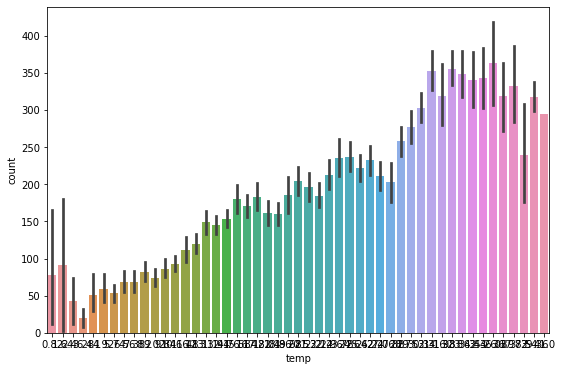

In [24]:
# barplot: 온도별 count
# boxplot
plt.figure(figsize = (9, 6))
sns.barplot(x = 'temp' , y = 'count', data = DF)
plt.show()

## 1. Linear Regression

In [47]:
def linearRegression(model_id, X, y, ts = 0.3, rs = 2045, poly = False , dg = 2) :

  # Split
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = ts,
                                                      random_state = rs)
  
  # Polynomial Features 
  if poly:
    pl = PolynomialFeatures(degree = dg , include_bias = False)
    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)

  # Model fitting
  LR = LinearRegression()
  LR.fit(X_train, y_train)

  # Model predict
  y_hat = LR.predict(X_test)

  # Model evaluation
  MSE = mean_squared_error(y_test, y_hat)
  score = np.sqrt(MSE)

  # Saving info in context
  context = {}
  context['model_id'] = model_id
  context['score'] = score


  return context

In [100]:
df_res = pd.DataFrame(data = None,
                      columns = ['model_id',
                                 'score'])

### 1) 다항회귀

- 월, 시간, 온도

In [101]:
X = DF[['month']]
y = DF['count']

res1 = linearRegression('LR-month' , X, y)
df_res = df_res.append(res1, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499


In [102]:
# 월, 다항회귀

res2 = linearRegression('LR-month-poly-2', X, y, poly = True, dg = 2)
df_res = df_res.append(res2, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661


In [103]:
res3 = linearRegression('LR-month-poly-3', X, y, poly = True, dg = 3)
df_res = df_res.append(res3, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204


In [104]:
# 시간 다항회귀
X = DF[['hour']]
y = DF['count']


res4 = linearRegression('LR-hour-poly-2', X, y, poly = True, dg = 2)
df_res = df_res.append(res4, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638


In [105]:
res5 = linearRegression('LR-hour-poly-3', X, y, poly = True, dg = 3)
df_res = df_res.append(res5, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708


In [106]:
res6 = linearRegression('LR-hour-poly-4', X, y, poly = True, dg = 4)
df_res = df_res.append(res6, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326


In [107]:
# 온도 다항회귀
X = DF[['temp']]
y = DF['count']

res = linearRegression('LR-temp-poly-2', X, y, poly = True, dg = 2)
df_res = df_res.append(res, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511


In [108]:
res = linearRegression('LR-temp-poly-4', X, y, poly = True, dg = 4)
df_res = df_res.append(res, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837


### 2) 다중회귀

- Case1: all

In [53]:
DF.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [109]:
X = DF[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour']]
y = DF['count']

In [110]:
res = linearRegression('LR-all', X, y)
df_res = df_res.append(res, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837
8,LR-all,142.240300


- case 2: day 제거

In [111]:
X = DF[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'hour']]
y = DF['count']

In [112]:
res = linearRegression('LR-drop_day', X, y)
df_res = df_res.append(res, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837
8,LR-all,142.240300
9,LR-drop_day,142.108897


## 2. Ridge/Lasso/ElasticNet Regression

In [113]:
# 규제 함수정의

def regularizer(model_id, X, y, ts = 0.3, rs = 2045, type = 'Ridge' , alpha = 0.3, ratio = 0.5) :

  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = 0.3,
                                                      random_state = 2045)

  if type == 'Ridge' :
    rg = Ridge(normalize = True,
            alpha = alpha,
            solver = 'cholesky')
    rg.fit(X_train, y_train)
    MSE = mean_squared_error(y_test, rg.predict(X_test))


  if type == 'Lasso' :
    ls = Lasso(normalize = True,
              alpha = alpha)
    ls.fit(X_train, y_train)
    MSE = mean_squared_error(y_test, ls.predict(X_test))

  if type == 'Elastic' :
    en = ElasticNet(normalize = True,
                    alpha = alpha,
                    l1_ratio = ratio)
    en.fit(X_train, y_train)
    MSE = mean_squared_error(y_test, en.predict(X_test))


  score = np.sqrt(MSE)

  context = {}
  context['model_id'] = model_id
  context['score'] = score
                
  return context

In [114]:
# day를 제거하고 Ridge
X = DF[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'hour']]
y = DF['count']

res = regularizer('RG-drop_day', X, y, type = 'Ridge', alpha = 0.3)
df_res = df_res.append(res, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837
8,LR-all,142.240300
9,LR-drop_day,142.108897


In [118]:
# day를 제거하고 Ridge- alpha 0.2
res = regularizer('RG-drop_day-0.01', X, y, type = 'Ridge', alpha = 0.01)
df_res = df_res.append(res, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837
8,LR-all,142.240300
9,LR-drop_day,142.108897


In [119]:
# day를 제거하고 Lasso (alpha = 0.3)

res = regularizer('LS-0.3', X, y, type = 'Lasso', alpha = 0.3)
df_res = df_res.append(res, ignore_index = True)
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837
8,LR-all,142.240300
9,LR-drop_day,142.108897


In [124]:
# day를 제거하고 Lasso (alpha = 0.1)

res = regularizer('LS-0.001', X, y, type = 'Lasso', alpha = 0.001)
df_res = df_res.append(res, ignore_index = True)
res

{'model_id': 'LS-0.001', 'score': 142.08202830064042}

In [125]:
# ElasticNet
res = regularizer('EN-0.0001-0.4', X, y, type = 'Elastic', alpha = 0.0001, ratio = 0.4)
df_res = df_res.append(res, ignore_index = True)
res

{'model_id': 'EN-0.0001-0.4', 'score': 143.87169564173544}

In [126]:
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837
8,LR-all,142.240300
9,LR-drop_day,142.108897


## 3. Decision Tree Regressor

In [129]:
def decisionTree(model_id, X, y, md = 3, ts = 0.3, rs = 2045, visualFeature = False, visualModel = False) :

  # Split
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = ts,
                                                      random_state = 2045)
  
  # Model fitting
  DT = DecisionTreeRegressor(max_depth = md,
                             criterion = 'mse',
                             random_state = 2045)
  DT.fit(X_train, y_train)



  if visualFeature:
    plt.figure(figsize = (9, 6))
    sns.barplot(DT.feature_importances_, X.columns)
    plt.title('Feature Importance')
    plt.show()


  MSE = mean_squared_error(y_test, DT.predict(X_test))
  score = np.sqrt(MSE)

  # Saving info in context
  context = {}
  context['model_id'] = model_id
  context['score'] = score

  return context

- Case1: all

In [130]:
X = DF[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour']]
y = DF['count']

In [131]:
# max_depth 3
res = decisionTree('DT-all-3' , X, y, 3)
print(res)
df_res = df_res.append(res, ignore_index = True)

{'model_id': 'DT-all-3', 'score': 127.10434525363067}


In [132]:
# max_depth 4
res = decisionTree('DT-all-4' , X, y, 4)
print(res)
df_res = df_res.append(res, ignore_index = True)

{'model_id': 'DT-all-4', 'score': 115.85320371166644}


In [133]:
# max_depth 5
res = decisionTree('DT-all-5' , X, y, 5)
print(res)
df_res = df_res.append(res, ignore_index = True)

{'model_id': 'DT-all-5', 'score': 106.78634819710204}


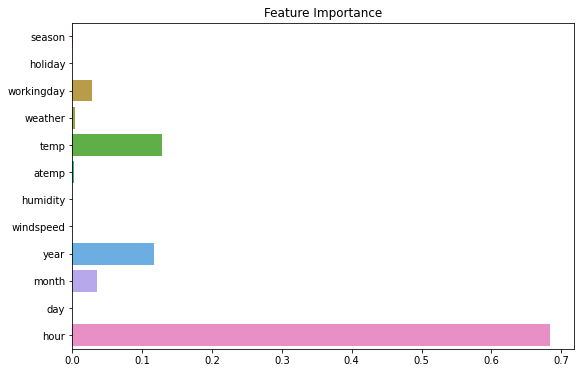

{'model_id': 'DT-all-6', 'score': 101.66729574299802}


In [153]:
# max_depth 6
res = decisionTree('DT-all-6' , X, y, 6, visualFeature = True)
print(res)
df_res = df_res.append(res, ignore_index = True)

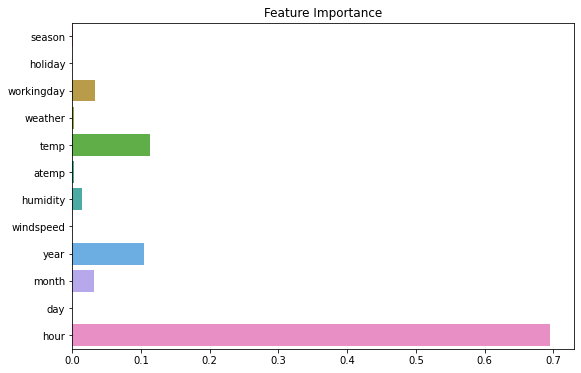

{'model_id': 'DT-all-7', 'score': 87.18744176595898}


In [154]:
# max_depth 7
res = decisionTree('DT-all-7' , X, y, 7, visualFeature = True)
print(res)
df_res = df_res.append(res, ignore_index = True)

### 4. Random Forest

In [190]:
def randomForest(model_id, X, y, n_est = 2000, mf = 'auto' , md = None, ts = 0.3, rs = 2045, visualFeature = True) :

  # Split
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = ts,
                                                      random_state = 2045)
  
  # Model fitting
  RF = RandomForestRegressor(n_estimators = n_est,
                             max_features = mf,
                             criterion = 'mse',
                             max_depth = md,
                             random_state = rs,
                             n_jobs = -1)
  RF.fit(X_train, y_train)

  if visualFeature:
    plt.figure(figsize = (9, 6))
    sns.barplot(RF.feature_importances_, X.columns)
    plt.title('Feature Importance')
    plt.show()

  MSE = mean_squared_error(y_test, RF.predict(X_test))
  score = np.sqrt(MSE)

  # Saving info in context
  context = {}
  context['model_id'] = model_id
  context['score'] = score

  return context

In [191]:
X = DF[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour']]
y = DF['count']

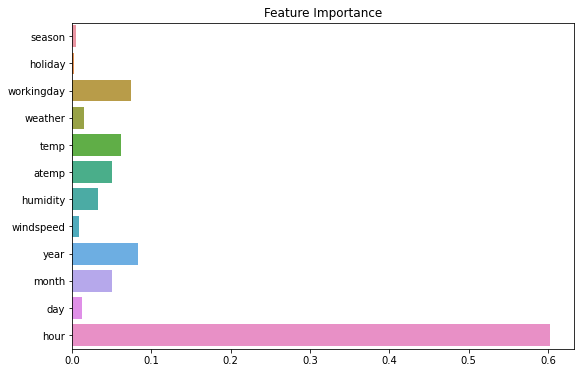

{'model_id': 'RF-all', 'score': 42.703273570982816}


In [192]:
res = randomForest('RF-all' , X, y)
print(res)
df_res = df_res.append(res, ignore_index = True)

In [160]:
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837
8,LR-all,142.240300
9,LR-drop_day,142.108897


### 5. GBM Regressor

In [166]:
X = DF[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour']]
y = DF['count']

def gbmRegressor(model_id, X, y, n_est = 9000, lr = 0.1, mf = 'auto', md = None) :

  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

  gbr = GradientBoostingRegressor(loss = 'ls',
                                  n_estimators = n_est,
                                  learning_rate = lr,
                                  criterion = 'mse',
                                  max_features = mf,
                                  max_depth = md)

  gbr.fit(X_train, y_train)

  score = np.sqrt(mean_squared_error(y_test, gbr.predict(X_test)))

  context = {}
  context['model_id'] = model_id
  context['score'] = score

  return context

In [180]:
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
3,LR-hour-poly-2,149.887638
4,LR-hour-poly-3,142.351708
5,LR-hour-poly-4,142.346326
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837
8,LR-all,142.240300
9,LR-drop_day,142.108897


In [181]:
for est in [10000, 15000, 20000] :
  for lr in [0.1, 0.01, 0.001] :
    for md in [5, 6, 7] :
      res = gbmRegressor('GBM-%s-%s-%s' %(est, lr, md), X, y)
      df_res = df_res.append(res, ignore_index = True)
      print(res)

# 유의미한 차이가 있는 것 같진 않다

{'model_id': 'GBM-10000-0.1-5', 'score': 59.84581842548023}
{'model_id': 'GBM-10000-0.1-6', 'score': 60.015899701820956}
{'model_id': 'GBM-10000-0.1-7', 'score': 59.63725808226711}
{'model_id': 'GBM-10000-0.01-5', 'score': 59.773580506015854}
{'model_id': 'GBM-10000-0.01-6', 'score': 59.85980689546867}
{'model_id': 'GBM-10000-0.01-7', 'score': 59.59859065625861}
{'model_id': 'GBM-10000-0.001-5', 'score': 60.11969113439546}
{'model_id': 'GBM-10000-0.001-6', 'score': 60.02785123812762}
{'model_id': 'GBM-10000-0.001-7', 'score': 59.84944653033179}
{'model_id': 'GBM-15000-0.1-5', 'score': 59.883268794283715}
{'model_id': 'GBM-15000-0.1-6', 'score': 60.010950905754726}
{'model_id': 'GBM-15000-0.1-7', 'score': 59.979707284607315}
{'model_id': 'GBM-15000-0.01-5', 'score': 59.90347467455116}
{'model_id': 'GBM-15000-0.01-6', 'score': 59.76132850968636}
{'model_id': 'GBM-15000-0.01-7', 'score': 59.92069062005486}
{'model_id': 'GBM-15000-0.001-5', 'score': 59.800899065279474}
{'model_id': 'GBM-15

In [184]:
def xgbRegressor(model_id, X, y, n_est = 9000, lr = 0.1, rl = 2.0) :

  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

  xgb = XGBRegressor(booster = 'gblinear',
                                n_estimators = n_est,
                                learning_rate = lr,
                                reg_lambda = 2.0,
                                n_jobs = -1)

  xgb.fit(X_train, y_train)

  score = np.sqrt(mean_squared_error(y_test, xgb.predict(X_test)))

  context = {}
  context['model_id'] = model_id
  context['score'] = score

  return context

In [187]:
res = xgbRegressor(1, X, y, rl = 1.0)
res

[07:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'model_id': 1, 'score': 148.06434044900612}

In [188]:
for est in [10000, 15000] :
  for lr in [0.1, 0.01, 0.001] :
    res = xgbRegressor('XGB-%s-%s' %(est, lr), X, y)
    df_res = df_res.append(res, ignore_index = True)
    print(res)

# 유의미한 차이가 없다

[07:50:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'model_id': 'XGB-10000-0.1', 'score': 148.0643406175369}
[07:50:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'model_id': 'XGB-10000-0.01', 'score': 148.0643413045768}
[07:50:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'model_id': 'XGB-10000-0.001', 'score': 148.0643407925578}
[07:50:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'model_id': 'XGB-15000-0.1', 'score': 148.0643418486093}
[07:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'model_id': 'XGB-15000-0.01', 'score': 148.06434029343433}
[07:51:14] WARNING: /workspace/src/objective/regression_obj.cu:152: re

In [201]:
# 불필요한 정보 삭제
df_res.drop(range(27,58), inplace = True)

In [210]:
df_res

,model_id,score
0,LR-month,177.581499
1,LR-month-poly-2,173.863661
2,LR-month-poly-3,173.854204
6,LR-temp-poly-2,166.164511
7,LR-temp-poly-4,166.123837
15,LS-0.3,150.666850
3,LR-hour-poly-2,149.887638
58,XGB-15000-0.001,148.064342
16,LS-0.2,145.957178
20,EN-0.0001-0.4,143.871696


In [208]:
df_res = df_res.sort_values(by='score', ascending=False)

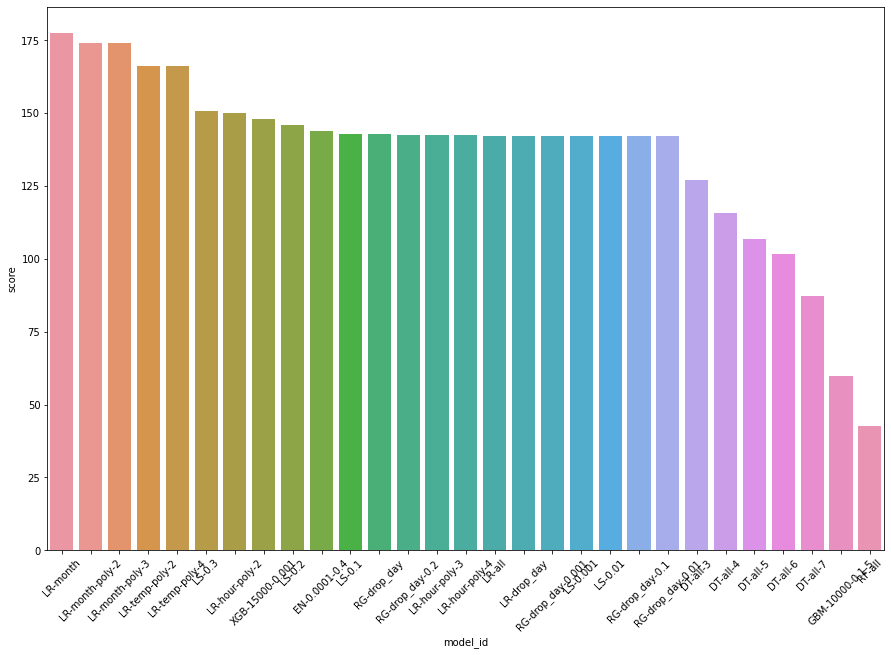

In [212]:
plt.figure(figsize = (15, 10))
sns.barplot(x = 'model_id', y = 'score', data = df_res)
plt.xticks(rotation = 45)
plt.show()